<a href="https://colab.research.google.com/github/rubanzasilva/mnist_basics/blob/main/Copy_of_mnist_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Imports

In [1]:
#hide
#This imports and sets up everything you will need for this notebook
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.2 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
#hide
from fastai.vision.all import *
from fastbook import *
import numpy as np

matplotlib.rc('image', cmap='Greys')

#Under The Hood : Training A Digit Classifier

Here we build a computer vision model from scratch using the we are using the famous [MNIST](https://en.wikipedia.org/wiki/MNIST_database#:~:text=Article%20Talk,the%20field%20of%20machine%20learning.), a dataset containing images of Handwritten digits. This was first used by Yan LeCun to build Lenet5, a handwritten digit classifier.

We do this while introducing the fundamental concepts and tools for deep learning such as

*   How to use NumPy arrays and PyTorch tensors
*   Application of broadcasting to them
*   Calculating gradients
*   Definition and choice of a loss function for our problem
*   Updating of the weights using Stochastic Gradient Descent and the role of mini batches.

We finally put all the math together to build a simple neural network to classify images

##Pixels : Computer Vision Foundations

First things first, lets consider how computers handle images.As we shall see later on, in a computer everything has to represented as numbers.
To do this we shall first download the dataset.

For the initial example, We are building a model to classify an image as a 3 or 7. With the code below, we download a sample from the original MNIST dataset which contains images of just these two digits.(3 and 7)

-download dataset
- create list containing folders
- view image, pil
-convert images to numpy array, pytorch tensors
-view images
-build baseline

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
#hide
Path.BASE_PATH = path

Fastai provides a method ls which we can use to see and get a count of whats inside the path directory.

This method returns an object of a special fastai class called L, which has the same functionality as a python's Buily in List but supports adavncwed functionality such as advanced indexing, additional methods and encourages use of expressive code making it easier to work with Python lists.




In [5]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

As we can see above, the dataset follows a common pattern for machine learning datasets, where the data is separated into separate train and valid folders.


In [6]:
(path/'train/3').ls()

(#6131) [Path('train/3/49077.png'),Path('train/3/4256.png'),Path('train/3/13836.png'),Path('train/3/11341.png'),Path('train/3/46702.png'),Path('train/3/48465.png'),Path('train/3/44191.png'),Path('train/3/51811.png'),Path('train/3/16407.png'),Path('train/3/31311.png')...]

In [7]:
(path/'valid/3').ls()

(#1010) [Path('valid/3/4256.png'),Path('valid/3/2011.png'),Path('valid/3/3717.png'),Path('valid/3/2501.png'),Path('valid/3/4703.png'),Path('valid/3/1204.png'),Path('valid/3/6116.png'),Path('valid/3/8924.png'),Path('valid/3/5408.png'),Path('valid/3/4492.png')...]

The training dataset is divided into 3 and 7 which contains images of digits for 3 and 7 respectively.The '3' and '7' are the labels in this dataset.

Lets us create a sorted list of our images for the 3's and 7's to ensure everybody gets the same order of files.

In [8]:
#we use sorted to ensure we get files in the order
threes = (path/'train/3').ls().sorted()
sevens = (path/'train/7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [9]:
#we use sorted to ensure we get files in the order
valid_threes = (path/'valid/3').ls().sorted()
valid_sevens = (path/'valid/7').ls().sorted()
valid_threes

(#1010) [Path('valid/3/1020.png'),Path('valid/3/1028.png'),Path('valid/3/1042.png'),Path('valid/3/1062.png'),Path('valid/3/1066.png'),Path('valid/3/1067.png'),Path('valid/3/1069.png'),Path('valid/3/1072.png'),Path('valid/3/1092.png'),Path('valid/3/1095.png')...]

In [10]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

We use the Image class from the Python Imaging Library (PIL) to display a sample image from the 3's folder.

Everything in a computer is represented as a number,To represent an image as a number in a computer, We have to convert it to a NumPy array or a PyTorch tensor as shown below.

In [11]:
im3_array = array(im3)
im3_array[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [12]:
im3_array

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29, 150, 195, 254, 255, 254, 176, 193, 150,  96,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  48, 166, 224, 253, 253, 234, 196, 253, 253, 253, 253, 233,   0

NumPy indexes from top to bottom and from left to right, as shown above with the 4:10 indicating the rows at the 4th index to the 9th index for both rows and columns.

The same applies to the tensor below.

In [13]:
im3_tensor = tensor(im3)
im3_tensor[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [14]:
df = pd.DataFrame(im3_tensor[4:30,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


Pandas Dataframe has an attribute df.style which returns a Styler object which contains methods for building a styled HTML representation of the DataFrame.

The set_properties method is used to set CSS properties for the each cell in the dataframe. In this case that is setting the font-size to 6pt for every cell.

The background_gradient method is used to add a gradient background color to the DataFrame. The intensity of the color is determined by the value in a particular cell with the lowest values being specified at the start of the gradient in this case 0 being white and vice versa.In this case, we are using grey which means that our values will range from black to white.

In summary, set_properties and background_gradient operations above will result in a dataframe with a font-size of 6pt and a gradient background color ranging from black to white.


Now the first question i had was cant you use the set_properties method to set the gradient background color as opposed to using the background_gradient method ?

Based on my research, i find out that set_properties can only set a static background color adn we would have to write a custom function that calculates the color for each cell based on the value and applies it using set_properties.

After taking a look at how our data looks like, we can go ahead to build a very simple model that recognizes 3's and 7's which we can use as our baseline.

## Baseline Model

A baseline model should be a simple to implement model that you are confident performs reasonably well, which we can use as our lower bound for the models we are building. We check if the models we are building are better than the baseline.

Starting with a simple reasonable baseline helps us ensure that the super complex models we build later on are any good.

### Pixel Similarity

For our baseline model, we can use the idea of pixel similarity.

Here we find the average pixel values for every pixel position for all image groups of 3's and 7's giving us two group averages, One representing the 3's and another the 7's.
This defines what we may call the "ideal" 3 and the ideal 7.

To classfify a random image as a 3 or 7, we see which of these two ideal digits the image is most similar to.

To build our model, we need to first stack all our respective images for each group together.First we convert our images to PyTorch tensors the same way we did for the individual images above.

We can use python list comprehension to turn our images in each folder into tensors for example

new_list = [f(0) for o in a_list if o>1].
This returns every element in **a_list** that is **greater than 1** after applying function, **f**.


####Ideal digits for 3 and 7.

In [15]:
threes_tensors = [tensor(Image.open(o)) for o in threes]
sevens_tensors = [tensor(Image.open(o)) for o in sevens]
len(threes_tensors), len(sevens_tensors)

(6131, 6265)

We can now view any of the image tensors using fastai's show_image function

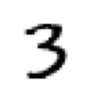

In [16]:
show_image(threes_tensors[1]);

We need to stack our list of image tensors into a single 3d tensor. We can do this using PyTorch's stack function.

Operations in PyTorch such as mean require floats so we cast our rank 3 tensor to float and divide it by 255 which is the max pixel value to get pixel values between 0 and 1.

In [17]:
stacked_threes = torch.stack(threes_tensors).float()/255
stacked_sevens = torch.stack(sevens_tensors).float()/255
stacked_threes.shape,stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

Here we see that for the threes we have 6131 image examples which is made up of a 28 x 28 matix.

To get our ideal numbers, we want to compute the mean value intensity for every image pixel position in each tensor.To do this we take the mean over the 0th dimension specified by passing in the argument 0 in the mean function.

This dimension indexes over all images and results in a single average pixel value for every position. We can view this single image tensor using show_image.

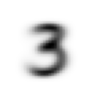

In [18]:
ideal_three = stacked_threes.mean(0)
ideal_seven = stacked_sevens.mean(0)
show_image(ideal_three);

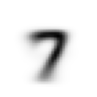

In [19]:
show_image(ideal_seven);

Now that we have our ideal digits, we can compute our pixel similarity which is the distance from an abitrary image and our ideal image which we are using as our initial baseline.


####Measuring Distance

How do we measure the distance from an abitrary number and an ideal number.One way would be to take the difference between each pixel position value for the abitrary and ideal images and add it up.

If we do this, we notice that some differences are positive while some are negative and this causes the differences to cancel themselves out leading a sitution where an image that is too dark and too light in some postions might be shown as having zero differences from the ideal which is misleading.

To avoid this data scientists usually measure distance in a different context by
- Instead we could take the mean of the absolute value of the differences where the absolute value function in this case replaces negative numbers with positive numbers. This is called the mean absolute difference or the L1 norm.

- Or we could take the mean of the square of the differences which makes the negative values positive, then take the square root to undo the squaring effect.This is called the Root Mean Squared Error (RMSE) or L2 norm.

So lets now pick a random three from our stacked tensor and get the L1 and L2 norm with the random and ideal number.

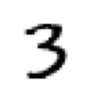

In [20]:
abitrary_three = stacked_threes[1]
abitrary_seven = stacked_sevens[1]
show_image(abitrary_three);

In [21]:
#L1 norm
distance_from_ideal_three_l1 = (abitrary_three - ideal_three).abs().mean()
distance_from_ideal_seven_l1 = (abitrary_three - ideal_seven).abs().mean()
distance_from_ideal_three_l1,distance_from_ideal_seven_l1

(tensor(0.1114), tensor(0.1586))

In [22]:
#L2 norm
distance_from_ideal_three_l2 = ((abitrary_three - ideal_three)**2).mean().sqrt()
distance_from_ideal_seven_l2 = ((abitrary_three - ideal_seven)**2).mean().sqrt()
distance_from_ideal_three_l2,distance_from_ideal_seven_l2

(tensor(0.2021), tensor(0.3021))

We see that in both cases the distance from the abitrary number to the ideal three is less than the distance from the abitrary number to the ideal seven.

This is as expected as the random number was a 3 meaning our simple baseline model gives the right prediction in both cases.

Luckily PyTorch provide both the L1 norm and the L2 norm as loss functions you can import from the torch.nn.functional module which are also provided by fastai. We shall import these as F and pass in the abitrary and ideal numbers as arguments.

In [23]:
F.l1_loss(abitrary_three.float(),ideal_three),F.l1_loss(abitrary_three.float(),ideal_seven)

(tensor(0.1114), tensor(0.1586))

In [24]:
F.mse_loss(abitrary_three,ideal_three).sqrt(),F.mse_loss(abitrary_three,ideal_seven).sqrt()

(tensor(0.2021), tensor(0.3021))

  So now that we have our baseline model, we need to calculate how good the model is which we can represent using a metric.

  Before we calculate a baseline lets look into the fundamental data structures we are working with, NumPy Arrays and PyTorch tensors.

#### NumPy Array and PyTorch Tensor data structures

Python is a slow language compared to most, anything fast in PyTorch is probably a wrapper of an object written, compiled and optimized in another language, usually C.
C is a low level programming language, which is very fast compared to python.

The fastai book describes Numpy Arrays and PyTorch tensors as follows



> A NumPy array is a multidimensional table of data of the same type. This can be any type i.e. a list, matrix, cube or even an array of arrays (jagged array).If items are all of some simple type e.g. int, floats etc., NumPy arrays can be stored as compact c data structures in memory.NumPy has a wide variety of operators and methods it can use to perform computation on these data structures at the same speed optimized C which is a multitude faster than Python. This is because they are written in optimized C.

> A PyTorch tensor is nearly the same thing as a numpy array, with the exception that the tensor can only be of a basic numerical type / simple type such as int, float etc for example a PyTorch tensor cannot be a jagged array, it will always be a multidimensional rectangular structure. PyTorch tensor can also live on GPU, and are also optimized for GPU, meaning it can perform faster computations given lots of values to work with.PyTorch also supports calculating gradients which is crucial for machine learning as our loss function, weight optimizations are calculated based of the gradients.
It would be impossible to do machine learning without this ability.





### Computing Metrics Using Broadcasting

Remember above, we have a baseline model that tells us how if a number is a 3 or 7. To do machine learning we need to know how good that model is, to do this we define a metric which is just a number that tells us how good our model is. We do this using the correct labels of the data and the predictions of the model.

We could use any of our above functions as a metric, in this case we shall use accuracy as the metric as it is more intepretable by end users.

We want to calculate our metric based on the validation set, as this data has not been seen by the model during training. Calculating our metric based of our training set will inadvertently lead to the model overfitting on the train set which results in poor results when the model sees new data.
Our baseline model has no training component, hence this doesn't matter but nonetheless we shall go ahead and use the validation set as a best practice.

Since we already have our ideal value for 3 and 7, we create a stacked tensor as done before using the validation set.

In [25]:
#We stack the sevens and threes in one tensor

#qfinal
valid_threes = (path/'valid/3').ls().sorted()
valid_sevens = (path/'valid/7').ls().sorted()

valid_three_tensors = [tensor(Image.open(o)) for o in valid_threes]
valid_seven_tensors = [tensor(Image.open(o)) for o in valid_sevens]

valid_stacked_threes = torch.stack(valid_three_tensors).float()/255
valid_stacked_sevens = torch.stack(valid_seven_tensors).float()/255

In [26]:
valid_stacked_threes.shape

torch.Size([1010, 28, 28])

We write a function is_3, which classifies a digit by determing which ideal number the abitrary number is closer to.
For this, we need to define some notion of distance by defining a function which calculates the distance between two images.We do this by defining a function which calculates the mean absolute error for image a and b as we had done before.

In [27]:
def mnist_distance(a,b):
  return (a-b).abs().mean((-1,-2))

mnist_distance(abitrary_three, ideal_three), mnist_distance(abitrary_three, ideal_seven)

(tensor(0.1114), tensor(0.1586))

In [28]:
#effect of .mean((-1,-2))

import numpy as np
foo = np.random.randn(4, 3, 2)
# array of 4 numbers and a single number
foo.mean(axis=(-1, -2)), foo.mean()

(array([ 0.34347965,  0.24843096, -0.77618452, -0.40627921]),
 -0.1476382809136289)

You will notice, we get the same values as previosly calculated for these images in distance_from_ideal_three_l1 and distance_from_ideal_seven_l1.

This is the distance from the ideal 3 to the abitrary number and the ideal 7 to the abitrary number. We have the distance for one image but we want to calculate the distance between the ideal number and all images in the dataset.


How do we go ahead doing this ? Traditionally we could create a python loop that takes each image tensor in our stack of shape torch.Size([1010, 28, 28]) which represents 1,010 28 x 28 pixel images stacked up and calculates the distance between each one and the ideal digits image tensor.

Something interesting happens if we define a variable which takes our tensor stacked with all the images as input for our mnist_distance function which we defined to calculate the distance between two images.



In [29]:
valid_three_distance = mnist_distance(valid_stacked_threes, ideal_three)
valid_three_distance

tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260])

In [30]:
valid_three_distance.shape

torch.Size([1010])

In [31]:
valid_stacked_threes.shape,ideal_three.shape

(torch.Size([1010, 28, 28]), torch.Size([28, 28]))

The valid_three_distance results in 1,010 different vector values of distance for every image tensor in the stack as opposed to returning an error complaining about mismatching shapes.

The trick here is broadcasting.When we perform a simple calculation such as (a-b) on two tensors of different ranks, Broadcasting expands the smaller tensor in memory, to have the same size as the larger tensor.

After broadcasting , PyTorch does it usual element wise subtraction.Lets take an example


In [32]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

This results in tensor([2,3,4]) which looks like an element wise addittion. PyTorch in this case treats tensor(1) as if it were three copies of the same tensor.Similary mean3, a rank 2 tensor representing a single image is treated as if it were 1,010 copies of the same image. It then subtracts each copy from an image in our valid_threes_dist calculating the distance between every 3 in the validation set and the ideal 3 resulting in 1,010 different values.

When PyTorch performs broadcasting, it doesnt actually copy the image 1,010 times. It just pretends that a tensor is of that shape but it doesnt actually allocate any memory for this.
PyTorch performs the whole computation in c code, and CUDA on GPU which is just C for GPU resulting in performance thousands of times faster than using pure python and millions of times faster on GPU.
This is true of all broadcasting and element wise operations and functions done in PyTorch.

In our function mnist_distance, we see .abs() which applies the method to every resulting element in a tensor returning a tensor that contains 1,010 absolute values.
Then finally we call .mean((-1,-2)) which contains a tuple of (-1,-2) which are a range of axes which represents the last and second last elements. This tells PyTorch that we want to take the mean ranging over values indexed by the last two axes of the tensor, which are the horizontal and vertical dimensions of an image. After this we are left with the first tensor axis which takes the mean over all images in the tensor, meaning we calculate the average intensity of all pixels for an image.

####**is_3**

We now define a function is_3 to determine whether an image is a 3 or a 7.


We can use mnsit_distance defined above to check whether an image is a 3 or 7 by using the following logic, if the distance between the selected image and the ideal 3 is less than the distance to the ideal 7, then the number is a 3.
We define a function is_3 with the above logic

In [33]:
#using a comparison or logical operator in a return statement of a function returns a boolean True Or False
#when the above value is converted to float, the function returns 1 for True or 0 for false.
def is_3(x):
    return (mnist_distance(x,ideal_three) < mnist_distance(x, ideal_seven))

In [34]:
def is_7(x):
  return (mnist_distance(ideal_seven, x) < (mnist_distance(ideal_three, x)))

In [35]:
is_3(ideal_three),is_3(ideal_seven)

(tensor(True), tensor(False))

In [36]:
is_3(ideal_three).float(), is_3(ideal_seven).float()

(tensor(1.), tensor(0.))

We can now run is_3 with the stacked_tensor of all images in it.This function will automatically apply broadcasting and do run this function elementwise for every image tensor.

In [37]:
is_3(stacked_threes), is_3(stacked_threes).float()

(tensor([True, True, True,  ..., True, True, True]),
 tensor([1., 1., 1.,  ..., 1., 1., 1.]))

In [38]:
is_3(valid_stacked_threes), is_3(valid_stacked_threes).float()

(tensor([ True,  True,  True,  ..., False,  True,  True]),
 tensor([1., 1., 1.,  ..., 0., 1., 1.]))

We take the average for all threes in the stacked tensor to get the accuracy for all the threes image tensors.
To get the accuracy for the sevens, we take the inverse of the same function.

In [39]:
accuracy_threes = is_3(valid_stacked_threes).float().mean()
accuracy_sevens = ( 1 - is_3(valid_stacked_sevens).float() ).mean()
accuracy_sevens_a = is_7(valid_stacked_sevens).float().mean()
accuracy_threes, accuracy_sevens, accuracy_sevens_a, (accuracy_threes + accuracy_sevens_a)/2


(tensor(0.9168), tensor(0.9854), tensor(0.9854), tensor(0.9511))

So we see we are getting over 90% accuracy for our model when classfying digits 3 and 7.

But 3 and 7 are only 2 numbers and they also look quite different, we need to build a system that contiunuosly improve and is more robust.As we see our baseline pixel similarity model has no way to improving or learning.

Lets try buidling a model that learns from previous predictions and automatically modifies itself to improve performance.We are going to see how we can train a model to learn.

In [40]:
#Boolean example
def is_test(a,b,c):
  return ((a-b) < (a-c))

is_test(6,8,4)

True

### Stochastic Gradient Descent

In 1962, Arthur Samuels described machine learning in his classic essay "Artificial Intelligence: A frontier of automation". Here he suggests that instead of telling a computer the exact steps need to solve a problem as in regular programming, we could just show a number of examples and let it figure out how to solve a problem itself. This indeed turned out to be a powerful idea, as was later shown.

Arthur Samuel's basic idea was

Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.

This spells out some powerful concepts
- The idea of weight assignment
- The fact that weight assignment has some actual performance that can be tested
- The idea that there needs to be an automatic means of testing the weight assignment
- The need for an automatic means of improving the performance by altering the weights

This is the key to building a model that continuously gets better, unfortunately our pixel similarity lacks a learning mechanism, meaning it cannot continuously get better. To take advantage of deep learning, we represent the problem in the form Arthur Samuels described above.
To do this, we use the concepts of weights, instead of calculating the distance between the pixels of an image and the ideal image, we assign weights to each pixel whereby the highest weights are associated with the pixels that are most likely to be black.
For example, if an image is a 7, the pixels in the bottom right corner are unlikely to be activated hence the pixels in the bottom right should have a low weight assignment for a 7 while if it was an 8 or a 9 say, the pixels would be activated hence they should have a high weight assignment for 8 or 9.
This can be represented as a function and a set of weight values for each category, for example the probability of being an 8 can be represented as below


In [41]:
def pr_eight(x,w):
    return (x*w).sum()

Here we assume that the x is an image with the rows stacked up into one line as a single tensor. w, represents the weights. With this we just need to update the weights in such a way that the model improves, we continuously improve the weights until we can't improve them any more, or we reach the selected number of epochs/iterations. We want the values of w to be high for numbers that are actually 8 and low for numbers that are not. With this just need to find the best weights for 8 to come up with the best function that can recognize 8's.

To find the above function into a machine learning classifier, we follow the specific steps
1. We initialize the weights
2. Using set weights, we calculate whether an image is a 3 or 7 and get predictions
3. Using predictions from step 2, we calculate our loss which tell us how good our predictions are
4. Based on the above loss, we calculate our gradients, which tell us how changing the weights affects the model
5. Based on above gradients, we change the weights in the direction that improves the model
6. Go back to step 2, and repeat the process
7. Iterate until you usually stop because the model is good enough, or you are tired of waiting

These steps are illustrated as shown below

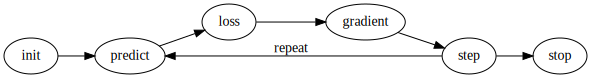

In [42]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')


There are several ways to perfrom the seven steps listed above, but they all follow some general guidelines
- initilize: we usually initialize the parameters to random values and because we have a means of automatically improving the weights, it means we shall iterate towards the correct weights no matter where we start at
- Loss : This refers to the means of testing the effectiveness of any current weight assignment in terms of actual performance such that the function returns a small number if the performance is good.
- Step, how do we know if we are taking the step in the right direction, we can try adjusting the loss in any direction and see if the loss goes up and down, with this we have the direction, then we take a step in the direction using different intensities until we find which amount works best.
  Calculating gradients gives us an exact direction and number in which to adjust our weights.

lets illustrate the above steps with a simple toy example where we assume that a quadratic function can work as as our loss function and x as the weight parameter.


In [49]:
def f(x):
    return x**2

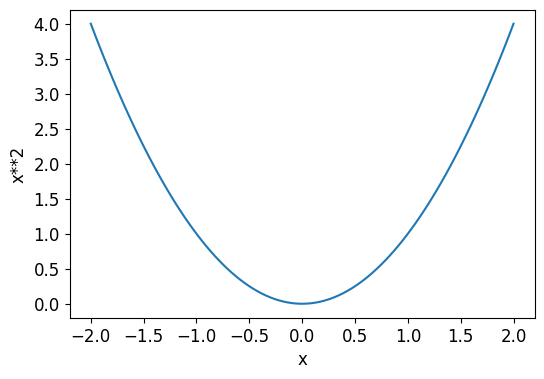

In [50]:
#Lets plot the following equation
#help(plot_function)
plot_function(f, 'x', 'x**2')

The sequence of the 7 steps start by picking or initializing the weight with a random parameter value and calculating the loss. Here we use -1.5 and calculate the loss.

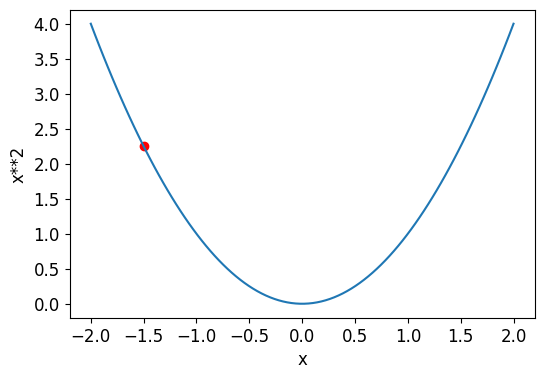

In [56]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5,f(-1.5), color="red")

We see how well our parameter value does and pick another value in the direction that improves the slope, lets try picking a higher and lower value to see which direction gets closer to the optimal point.

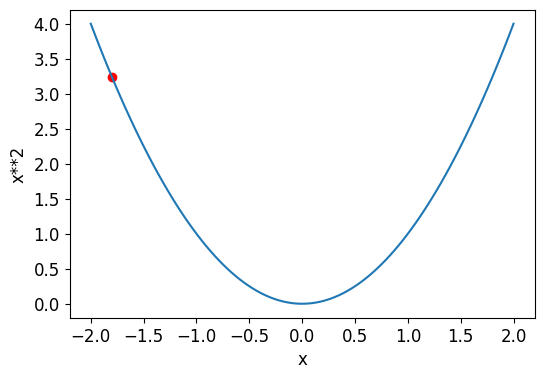

In [58]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.8,f(-1.8), color="red")

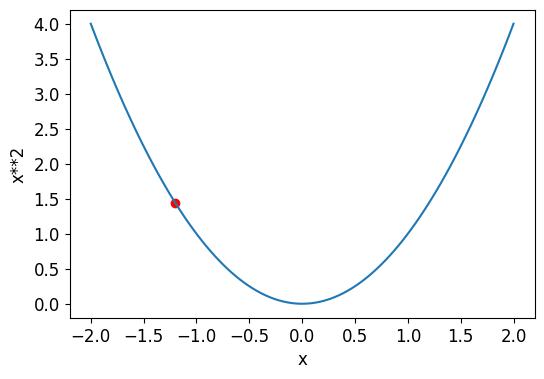

In [59]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.2,f(-1.2), color="red")

With this, we see that taking lower values moves us closer to the lowest point on the curve, with this we continously adjust our weights until we reach the lowest point on the curve that minimizes the loss.We continously adjust our weights in the right direction until we reach the lowest point on the curve.

We can optimize functions regardless of how complex they are this way with gradient decsent until we reach the otpimal point.


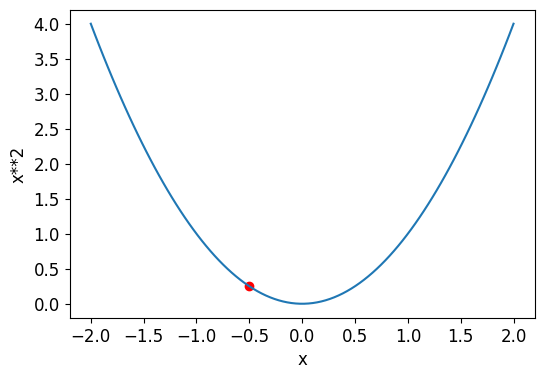

In [60]:
plot_function(f, 'x', 'x**2')
plt.scatter(-0.5,f(-0.5), color="red")

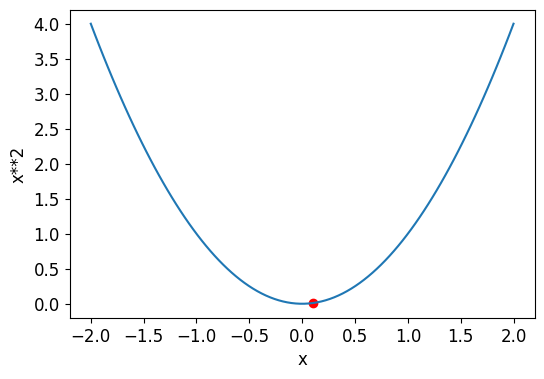

In [61]:
plot_function(f, 'x', 'x**2')
plt.scatter(0.1,f(0.1), color="red")

### Gradients

Instead of manually adjusting the weight value, we can use calculus as a performance otpimization. This basically tells us how much our loss will go up or down when we adjust our parameter in a given direction telling us which direction to adjust our weight and by how much.

From calculus, we know that a derivative of a function tells us how much a change in its parameters changes the result of a function.For any given function such as our quadratic function above, we can calculate its derivative which is just another function. We should note that the derivative of a function calculates the rate of change of the function not the value of the function.

For example the derivative of our quadratic function at parameter value 3 tells us how much the quadratic function changes at 3.Once we know how our value changes we know what direction to adjust our weights in to make the function smaller.
This is the key to machine learming, having a way to adjust the parameters to improve the model. Calculus provides a computational shortcut which lets us calculate the gradients of a function.These tells us which direction and by how far to adjust our weights.

Remember that our function has a lot of weights that we need to adjsut.Intrestingly enpouh, we can calculate the gradient for each weight while taking the rest constant, then do this for each weight using broadcasting.

We dont need need to calculate the gradients manually as PyTorch can do this for us.

#CHECKPOINT

Calculus tells us how much our loss will go up or down when we adjust our parameter values up or down.
A derivative of a function tells us about the rate of change of a function not the function value.
Remember that a function usually has a bunch of gradients, here we calculate the gradient for each weight while taking the rest as constant, then repeat this for each weight.

PyTorch can automatically calculate gradients for us but first lets pick a value where you want to calcualte derivatives of

In [ ]:
#this tells pytorch to calculate gradients with respect to a variable at the value,3
#x values
xt = tensor(3.).requires_grad_()

In [ ]:
#yt prints out the values and the gradient function it uses to calculate gradients when asked to
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [ ]:
#backward pass/ backpropagtion where we calculate the drivatives
yt.backward()

In [ ]:
#We can view the gradient by calling the grad attribute of our input tensor
xt.grad

tensor(6.)

The derivative of x**2 is 2*x, hence 2*3 results in 6 as shown above.Lets do the same for multiple values.

In [ ]:
xt = tensor([3.,4.,5.]).requires_grad_()
xt

tensor([3., 4., 5.], requires_grad=True)

We redefine our function f(x) adding sum so the function takes a vector rank 1 tensor and converts into a scalar 0 rank tensor

In [ ]:
def f(x):
    return (x**2).sum()

yt = f(xt)
yt

tensor(50., grad_fn=<SumBackward0>)

In [ ]:
yt.backward()

In [ ]:
xt.grad

tensor([ 6.,  8., 10.])

This gives us the slope of a function, they dint actually tell us how far to adjust the parameters but it gives us an idea, large slope means we still have alot of adjustment to do while a small slope means we are closer to the optimum value.

Stepping with learning rate

This involves changing the weights/parameters based on the gradients. It is commonplace to multiply the gradient values by a small number usually between 0.001 and 0.1 called the learning rate.This results in new paramter values.We can adjust the learning rate as follows

In [ ]:
w = -gradient * lr

We usually adjust our paramters in the direction of the slope as we are trying to find the minimum.The - ensures that the we increase the paramter if the slope is negative and we decrease the parameters if the slope is positive.

Example of SGD.

Here we use the gradients to find the minimum and we see how finding a minimum can be used to train a model to better fit the data.

Description
Say you are measuring the speed of a roller coaster every 20 seconds as it goes over a hill , and slopes back down.
The roller coaster would start fast, getting slower as it climbs the hill, would be slowest at the top then slowly accelerate and pick up speed as it descents down the hill.

In [ ]:
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

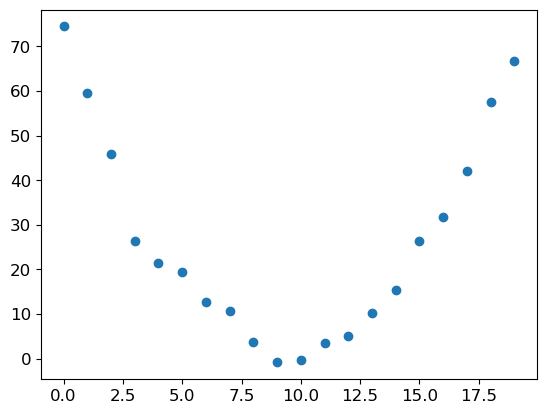

In [ ]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

Using stochastic gradient descent, we can build a function that matches the data. Lets start with a quadratic in the format ax**2 + bx + c assuming that this function can fit and match our observations

In [ ]:
#time is the input and a,b,c are the parameters
a(time)**2 + b(time) + c

In [ ]:
#function that takes input and parameters as input and returns a prediction
def f(t, params):
    a,b,c = params
    return a*(t**2) + b*t + c

We distinguish clearly between the functions input and the parameters in the function above. What we have done is restrict the problem of finding the best quadartic that fits to finding the best paramter values for a,b, and c which greatly simplifies our problem as every quadrastic is fully defined by 3 paramaters a,b,c.
In order to find the best quadratic function we  find the best values of a,b and c.

If we can solve the problem above, we can apply the same logic to solve other problems such as our mnist classification with more complex functions and parameters just like we are doing above. We also need to define what we mean by best values. We do this by choosing a loss function where smaller values correspond to bette predictions and vice versa.For the above continous data, we shall use mean squared error

In [ ]:
#loss function
def mse(preds,targets):
    return ((preds - targets)**2).mean()


We now go through our seven step process

In [ ]:
#intialize and tell pytorch to compute gradients
params = torch.rand(3).requires_grad_()
orig_prams = params.clone()

In [ ]:
params

tensor([0.5779, 0.9040, 0.5547], requires_grad=True)

In [ ]:
#Calculate predictions
preds = f(time, params)
preds

tensor([  0.5547,   2.0366,   4.6743,   8.4679,  13.4174,  19.5227,  26.7839,  35.2009,  44.7737,  55.5025,  67.3870,  80.4274,  94.6237, 109.9758, 126.4838, 144.1476, 162.9673, 182.9428, 204.0741,
        226.3614], grad_fn=<AddBackward0>)

In [ ]:
len(preds)

20

In [ ]:
def show_preds(preds, ax=None):
 if ax is None: ax=plt.subplots()[1]
 ax.scatter(time, speed)
 ax.scatter(time, to_np(preds), color='red')
 ax.set_ylim(-300,100)


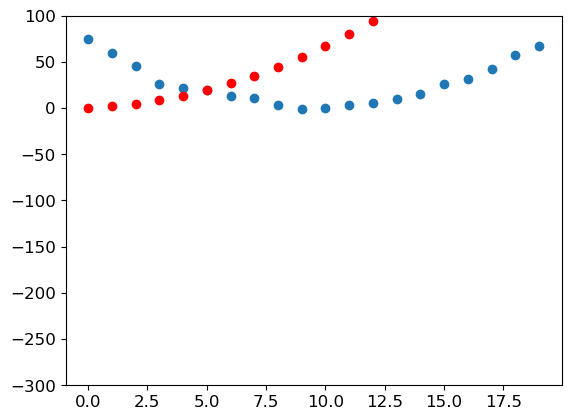

In [ ]:
show_preds(preds)

In [ ]:
#calculate the loss
loss = mse(preds,speed)
loss

tensor(7761.0767, grad_fn=<MeanBackward0>)

In [ ]:
#calculate gradients
loss.backward()
params.grad

tensor([28189.2148,  1824.8007,   107.8606])

In [ ]:
lr = 1e-5

In [ ]:
i = params.data
i

tensor([0.5779, 0.9040, 0.5547])

In [ ]:
u = params.grad.data
u

tensor([28189.2148,  1824.8007,   107.8606])

In [ ]:
lr = 0.05
params.data = - lr * params.grad.data

In [ ]:
#new params after adjustmemt
#params.data represents the initial parameters
#params.grad.data represents the gradients of these initial paramters
# lr * params.grad.data changes multiplies the gradients of the parameters by a learning rate
#params.data = - lr * params.grad.data sets the initial parameters to the result of gradients * lr
#
i = params.data
i

tensor([-792.6697,  -51.2920,   -2.6360])

In [ ]:
#step
lr = 1e-5
params.data = - lr * params.grad.data
params.grad = None

In [ ]:
#go back to step 2
preds = f(time,params)
loss = mse(preds, speed)
loss

tensor(5674.8853, grad_fn=<MeanBackward0>)

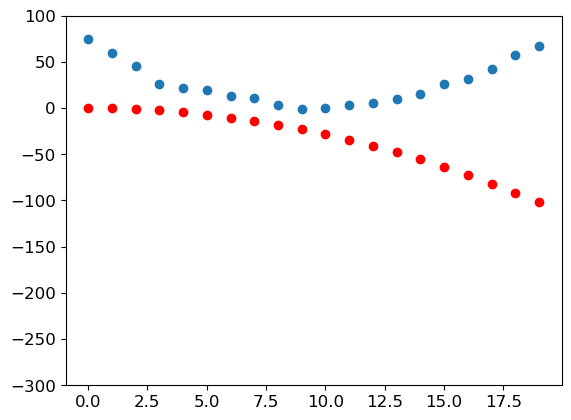

In [ ]:
show_preds(preds)

In [ ]:
#We need to do this a couple of times so we create one step
def apply_step(params,prn= True):
    preds = f(time,params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -=  lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [ ]:
for i in range(10):
    apply_step(params)

5674.88525390625
1642.954833984375
879.9871215820312
735.607177734375
708.2830810546875
703.1094970703125
702.1275024414062
701.9385986328125
701.9000244140625
701.8897094726562


In [ ]:
orig_prams

tensor([0.5779, 0.9040, 0.5547], grad_fn=<CloneBackward0>)

In [ ]:
params = orig_prams.detach().requires_grad_()


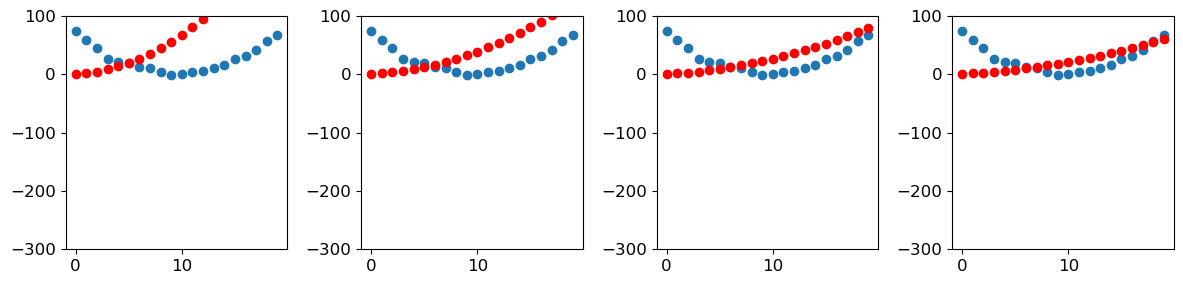

In [ ]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

To summarize at the beginning, we initialize the weights to random values, since we have a means of improving them or we can use weights from a pretrained model.
In the first example, the initial weights wont be much good as well as in the second case.

Once we have weights, we can use these to calculate a prediction. We then compare our prediction with our target which in this case is our labels, which we already have as we are using a labelled dataset.
This gives us a number which we refer to as our loss, this measures the distance between the predictions and the target to tell us how good our model is.
We now have a number that we want to make as low as possible as low values of loss correspond with better predictions.

We can make the loss as low as possible by adjusting the parameters of the model also called the weights in the direction that minimizes the loss.
Calculus gives us a way to calculate which direction to adjust our weights in, calculating the gradients of the above. We adjust the weights by taking the gradients and multi[plying them by a small learning rate. We then contiously iterate until we reach the lowest point


All the above steps can be transposed and applied to the mnist dataset except the loss function. So lets now build a loss function for our mnsit dataset and apply the seven steps

##MNIST LOSS FUNCTION

We already have the independent variables, x which are the images themselves. We concatenate them into a single tensor and also change them from a list of matrices to a list of vectors, we do this using .view() a PyTorch method thay changes the shape of a tensor without changing its content. -1 is a special paramter for -1 that tells PyTorch to make this axis as big as neccesary to fit all the data.

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1,28*28)

In [ ]:
#train_x = torch.cat([all digits]).view(-1,28*28)

We also need labels for our dataset, in this case we use 1 for the 3's and 0 for the 7's.

In [ ]:
#unsqueeze(1) adds an extra dimension of 1 to the train_y
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

In [ ]:
#train_y = tensor([0]*len(zeros) + [1]*len(ones) + [2]*len(twos)).unsqueeze(1)

In [ ]:
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A DataSet is supposed to return a tuple of (x,y) when indexed. We can use the zip function which when combined with the list function provides a simple way to return this.

In [ ]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [ ]:
Image.open(valid_threes[1])

In [ ]:
valid_x = torch.cat([valid_stacked_threes, valid_stacked_sevens]).view(-1,28*28)
valid_y = tensor([1]*len(valid_threes) + [0]*len(valid_sevens)).unsqueeze(1)
dset = list(zip(valid_x,valid_y))


Sevens steps

In [ ]:
#initiliaze parameters
def init_params(size,std=1.0):
    return (torch.randn(size)*std).requires_grad_()

#nb : what does std do in init_params function, it provides more variance in the parameters though this does nothing as it is a 1.

#https://forums.fast.ai/t/mnist-loss-function-and-prediciton/81798/4

also explains why we use weights.T which transposes the weights from a 784 * 1 to a 1 * 784 when calculating a prediction

In [ ]:
weights = init_params(28*28,1)

In [ ]:
weights

The function weights * pixels wont be flexible enpough as it always returns 0 when the pixel is 0.The formula for a line is y = mx + b meaning we shall still need a b.we initilize it to a random number too.

In [ ]:
bias = init_params(1)
bias

tensor([0.6653], requires_grad=True)

In a neural network the w represents the weights and the b represents the bias and together the weights and biases represent the parameters of a neural network.

In [ ]:
#prediction for 1 image
pred = (train_x[0]*weights.T).sum() + bias
pred

/tmp/ipykernel_550/1078514746.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1696859728060/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  (train_x[0]*weights.T).sum() + bias


tensor([20.3636], grad_fn=<AddBackward0>)

NB: .T seems to be depreceated
/tmp/ipykernel_550/1078514746.py:2:

 UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release.

Consider `x.mT` to transpose batches of matrices

or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor.

(Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1696859728060/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  (train_x[0]*weights.T).sum( + bias



While we could use a python for loop to calculate the predictions for each image, python for loops dont run on GPU and because python is also a slow language for loops in general, we need to represent as much of the calculation/computation in a model as possible using higher level functions as possible.

We use matrix multiplication which is represented in python as an @ operator as shown below.

In [ ]:
#a function to return predictions for all images
def linear1(xb):
    return xb@weights + bias

In [ ]:
preds = linear1(train_x)
preds

tensor([20.3636, 11.2542, 11.3436,  ..., 11.0615,  4.1023, 13.1092], grad_fn=<AddBackward0>)

In [ ]:
preds.shape

torch.Size([12396])

This equation batch@weights + bias is one of the two fundamental equations in deep learning with the other being the activation function which we shall see in a bit.

Lets check our accuracy.To decide whether the numbers are a 3 or 7, we just check whether its greater than 0,and our accuracy for each image is calculated using broadcasting (no loops) as shown below

In [ ]:
corrects = (preds > 0.0 ).float() == train_y
corrects

tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [ ]:
corrects.shape

torch.Size([12396, 12396])

In [ ]:
corrects.float().mean().item()

In [ ]:
#change one weight and calucalate the new accuracy
#torch.no_grad tells pytorch not to calculate gradients
with torch.no_grad():
    weights[0] *= 1.0001
    preds = linear1(train_x)
    (preds>0.0).float() == train_y).float().mean().item()

To improve our model using SGD, we need to calculate gradients which means we need a loss fucntion that represents hpw good our model is.The gradients are a measure of how the loss function changes with respect to the change in weights, so we definetly need a loss function.

One option would be to use accuracy, which would get the prediction for one image for every image in the dataset, calcualte the avergae accuracy over the whole dataset and then calcualte the gradients for each weight of an image with respect to the overall accuracy.

Accuracy doesnt repond to small changes in the weights hence it wont be useful as a loss function.

The gradient of a function is its slope/stepness i.e. rise over run, which is how much the value of the function goes up or down divided by how much the input changed.(y_new - y_old)/(x_new - x_old).

This gives us a good approximation of the gradients when x_new is very similar to x_old, meaning their difference is very small. But accuracy only changes when a prediction changes from 3 to 7 or vice versa. The only problem is a small change in weights from x_old to x_new isnt likely to cause any prediction change, so y_new- y_old will almost always be 0, making the gradient 0 which is not a number a model can learn from.
Basically a small change in weights doesnt result in a change in prediction, hence the gradient at that point will almost alwaysa be zero until the precition changes.This number 0 doesnt teach the model anything.

We need a loss function which when our weights result in slighty better predictions gives us a slightly better loss.In this case if the answer is a 3, the answer is a little higher and if the answer is a 7, the loss is a little lower.

Lets write this function which takes in the predictions as input. Lets make an argument prds of values between 0 and 1, where each value is the prediction that a number is a 3.
Lets make another argument trgts which are the targets between 0 and 1 which tells whether an image is a 3 or not.
A loss function calculates the difference between the predicted images and the targets.

"calculate the loss, get gradients, update params based on grad, repeat".

For instance, we might have three numbers which are 3, 7, 3.We pass these to the model which returns prediction of (0.9) for the first where the model predicted with high confidence that the value was a 3, the second value is a (0.4) where the model was fairly confident the number was a 7, and with fair confidence but incorrectly that the last was a 7 (0.2). Since 0.9, 0.4 and 0.2 are the prediction, we pass these to the model as input.

In [ ]:
trgts = tensor([1,0,1])
prds = tensor([0.9,0.4,0.2])

In [ ]:
def mnist_loss(predictions, targets):
    return torch.where(targets == 1, 1-predictions, predictions).mean()

This calculates the distance between the target and 1 if it is supposed to be a one and the distance to 0, if its is supposed to be a 0. We then take the mean of those distances.

Lets try it on our prds and tgts

In [ ]:
torch.where(trgts == 1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [ ]:
mnist_loss(tensor([0.9,0.4,0.2]),trgts)

tensor(0.4333)

In [ ]:
mnist_loss(prds,trgts)

tensor(0.4333)

This function returns a lower number when the predictions are more accurate, when accurate predictions are more confidentand when inaccurate predicitons are less confident.We take the mean to give us a scalar for the final loss.With loss, a low number is always assuemned to be better i.e if we changed our last p[rediction from 0.2 to 0.8 inidcating high confidence in the number being a three our loss goes down as shown below.

In [ ]:
mnist_loss(tensor([0.9,0.4,0.8]),trgts)

tensor(0.2333)

Our mnist loss function currently assumes that the preds are between 0 and 1. we need to ensure that is true.

Luckily enough, there is a function that does just that.

Sigmoid

The sigmoid function always outputs a number between 0 and 1.It takes in any value as input and squishes it into a value between 0 and 1.

It is defined as follows

In [ ]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

Luckily enough PyTorch defines a sigmoid function for us, so we dont need to define one.

In [ ]:
help(plot_function)

Help on function plot_function in module fastbook:

plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6, 4))



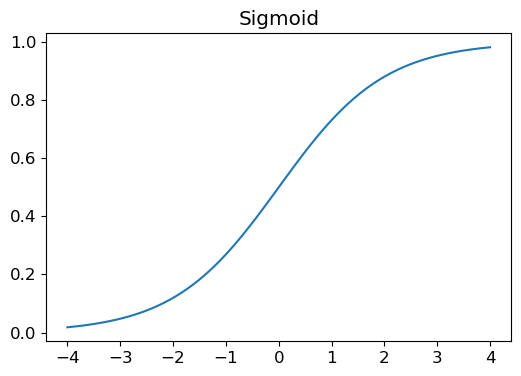

In [ ]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

As we can see the above function is a smooth curve that goes up, which is the type of function that gives us meaningful derivatives.This means that the function responds to small changes in the gradients.

With this we update our mnist function as below

In [ ]:
#calculates distance from 1 if target is 1,and distance from 0 if target is 0.
def mnist_loss(predictions,targets):
    predictions = prediction.sigmoid()
    return torch.where(target == 1, 1 - predictions, predictions)

With this our loss function will work even the predictions are not between 0 and 1. All that is required is that higher values of predictions correspond to s higher confidence an image is a 3.

We already have a metric so the question would be why did we define a loss function ?

A metric is used to drive human understanding of how our model is actually performing while a loss function is to drive machine learning.To drive automated learning we need a function which returns meaningful derivatives and responds to small changes in the confidence level.
This means that sometimes the loss function is not exaclty an approximation of what we want to achieve, but a compromise between the real goal and a function that can be opimtimized with gradients.

The loss function is calculated for every item in the dataset and the end of our epoch the loss values are averaged to give us a single scalar value of the mean loss for each epoch.

Metrics on the other hand show us how a model is really doing, we usually look at this  metric when judging the performance of a model.

SGD AND MINI-BATCHES

The next step is to change the weights based of the gradients and learning rate, This is called the optimization step.

While taking the optimization step, we take the loss over a couple of data items in the dataset.Taking the loss for all the items in the dataset will take long though yield more accurate gradients while taking the loss for one item will result in unstable gradients as calculating the loss on one item does not yield enough information to be helpful i.e. we would be updating the weights in relation to how those weights improve the perfromance of that one item.

A compromise would be to take the average loss for a couple of data items in the dataset at a time, this is called the mini batch.The number of data items in a batch is called the batch size.

A large mini batch learns more stable and useful gradients but takes longer to converge and you end up having less mini batches per epoch. Deciding on a good batch size is one of the decisions you make as a deep learning practioneer when building models.

Another good reason we want to use mini batches as opposed to using one data item is that in real-world we mostly used accelerated compute such as GPU's which work very well when provided with a lot of work to do, though if you provide too much you will run out of memory.

random shuffle

In practice we get better generalization if we can vary things abit during training as shown in the antelope classifier blog.

Instead of enumerating our dataset in order for every epoch, We can vary the items by randomly shuffling the items for every epoch before we create a mini batch.PyTorch and fastai provide a class DataLoader that does the shuffling and mini batch collation for us.

A DataLoader takes any python collection such as a list etc. and turns it into an iterator over mini batches as shown below

In [ ]:
coll = range(15)

In [ ]:
list(coll)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [ ]:
dl = DataLoader(coll, batch_size = 3, shuffle=True)
list(dl)

For training a model, we dont just want any collection but a collection containing the independent and dependent variables (inputs and targets). A collection containing the independent and dependent variables in PyTorch is known as a dataset.  
This is why when indexed it returns a tuple of (x,y) as shown in the initial definition for dset.

When we pass a dataset to a DataLoader, we gain back a mini batch contaning a tuple of tensors containing batches of independent and dependent variables.

With this, lets write  training loop using SGD.

Putting it all together

Here we fully implement our 7 step process that we saw in gradient descent.
Our process shall be implemented as something like this

In [ ]:
for x,y in dl:
    prediction = model(x)
    loss = loss_function(prediction, y)
    loss.backward()
    paramters -= parameters.grad * lr

First lets redo our 7 steps

In [ ]:
help(init_params)

Help on function init_params in module __main__:

init_params(size, std=1.0)
    #initiliaze parameters



In [ ]:
#reinitialize params
weights = init_params(28*28,1)

In [ ]:
bias = init_params(1)

In [ ]:
dset = list(zip(train_x,train_y))

In [ ]:
dl = DataLoader(dset, batch_size = 256, shuffle = True)
#what does first(dl) do
xb, yb = first(dl)
xb.shape, yb.shape

In [ ]:
valid_dl = DataLoader(list(zip(valid_x, valid_y)), batch_size= 256, shuffle=True)

In [ ]:
#Mini batch
batch = train_x[:4]
batch

In [ ]:
valid_batch = valid_x[:4]
valid_batch

In [ ]:
#linear1
def linear1(xb):
    return xb@weights + bias

In [ ]:
#make predictions
preds = linear1(batch)
preds

In [ ]:
#calculate the loss
#valid_batch = train_y[:4]
#loss = mnist_loss(preds, valid_batch)
loss = mnist_loss(preds, train_y[:4])

In [ ]:
loss.backward()

In [ ]:
weights.grad.shape, weights.grad.mean(), bias.grad

Lets put what we have done so far in a single function

In [ ]:
def calc_grad(xb,yb,model):
    preds = model(xb)
    loss = mnist_loss(preds,yb)
    loss.backward

In [ ]:
#test out calc_grad
calc_grad(batch,valid_batch,linear1)
weights.grad.mean(),bias.grad

We test the function a second time

In [ ]:
#test out calc_grad again
calc_grad(batch,valid_batch,linear1)
weights.grad.mean(),bias.grad

When calculating gradients,we see that loss.backward() actually adds the gradients computed to the gradients previously computed and stored. For this reason we always set the gradients to 0 whenever we calculate gradients.

We add .zero() to weights.grad and bias.grad (the parameters gradients) which is an inplace operation that sets all elements of the tensor to 0.

We now have to make a step where we update the weights and biases based on the gradients and the learning rate. While doing this, we have to tell PyTorch not to calculate the gradient at this point too. We do that by assigning our parameters a data attribute which tells PyTorch not to take gradients at that step.

Below is our basic training loop

In [ ]:
def train_epoch(model,lr,params):
    for xb,yb in dl:
        calc_grad(xb,yb,model)
        for p in params:
            p.data -= p.grad * lr
            p.data.zero_()

Accuracy check

To check whether a number is a 3 or a 7, we can check whether the predixtion is greater than 0.

Our accuracy for each item is calculated

In [ ]:
(preds>0.0).float() == train_y[:4]

This gives us a function to calculate accuracyas defined below

In [ ]:
def batch_accuracy(xb,yb):
    preds = xb.sigmoid()
    corrects =(preds>0.5) == yb
    return corrects.float().mean()

In [ ]:
batch_accuracy(linear1(batch),train_y[:4])

Put all batches together

In [ ]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb),yb)] for xb,yb in dl]
    return round(torch.stack(accs).mean().item(),4)

In [ ]:
validate_epoch(linear1)

Lets put together all the above for one epoch

In [ ]:
#one epoch
lr = 1
params = weights, bias
train_epoch(linear1,lr,params)
validate_epoch(linear1)

In [ ]:
#We do a couple more epochs
for i in range(15):
    train_epoch(linear1,lr,params)
    print(validate_epoch(linear1), end='')

So as we see our model above is enough to atleast match the pixle similarity model we created before and provides a general fpundation we can build on

Our next step will be to create an object called an optimizer in PyTorch, which handles our SGD step for us.

Optimizer

PyTorch provides some classes to make the above SGD step we took easier to implement.

Our first step would be to replace the linear1 function with PyTorch's nn.linear module.
A module is an object of a class that inherits from PyTorch's nn.Module class.

Objects of this class behave identically to PyTorch functions in that you camn call them using standard parantheses and they will return activations  of a model.

nn.linear does the same things as our init_params and linear1 together containing both weioghts and biases in a single class.

We replicate the model from above as shown below

In [ ]:
#replace init_params definition and initialization
#replace bias definition and initialization
#replace linear1 definition
linear_model = nn.linear((28*28),1)

Every PyTorch module knows what parameters it has that can be trained, they can be accesed through the paramters method

In [ ]:
w,b = linear_model.parameters()
w.shape, b.shape

We can use this information to create an optimizer

In [ ]:
class BasicOptim:
    def __init__(self,params,lr):
        self.params, self.lr = list(params),lr

    def step(self,*args,**kwargs):
        for p in self.params:
            p.data -=  p.grad.data * self.lr

    def zero_grad(self,*args,**kwargs):
        for p in self.params:
            p.grad = None


In [ ]:
#We can now create our optmizer by passing in a model's paramters
opt = BasicOptim(linear_model.paramters(),lr)

In [ ]:
#We simplify our training loop
#we remove lr and params from our model definition
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb,yb,model)
        opt.step()
        opt.zero_grad()


In [ ]:
#our validation_epoch deosnt change
validate_epoch(linear_model)

In [ ]:
def train_model(model,epochs):
    train_epoch(model)
    print(validate_epoch(model), end='')

In [ ]:
train_model(linear_model,20)

fastai provides the SGD class which does the same thing as our BasicOptim

In [ ]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.paramters(),lr)
train_model(linear_model,20)

fastai also provides Learner.fit which we can use as our train_model function defined above. To create a learner, we first need to create a DataLoaders, by passing in our training and validation DataLoader 's

In [ ]:
dls = DataLoaders(dl, valid_dl)

To create a learner without using a specific application such as vision_learner, we need to pass in all the elements we have created in this chapter i.e. the DataLoaders, The model, the optimization function which is passed the paramters, the loss function and ,metrics if any.

In [ ]:
learn = Learner.fit(dls, nn.linear((28*28),1), opt_func=SGD, loss_func = mnist_loss, metrics=batch_accuracy)

In [ ]:
#now we call fit
learn.fit(10, lr=lr)

PyTorch and fastai classes are convinently pre-packaged pieces of code that make work somewhat easier.

With all these classes defined, we can then replace a linear model with a neural network.

Adding Non-linearilty

#remember since we have the general procedure for optimizing the parameters of a function, to turn the above declared learn.fit into one with neural nets instead of a linear model,we repalce the model (nn.linear(28*28,1)) with the simple_net declared below

So far we have a general procedure for optimizing the parameters of a function, and we tried it out on a very simple function i.e. a linear classifier.This linear classifier is contrained in terms of what it can do, To make it abit more complex and handle more tasks, we need to add something non linear between two linear classifiers, this is what gives us a neural network.

Below is the entire definition of a basic neural network

In [ ]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

All, we have in our simple net is two linear classifiers with a max function between them.

w1 and w2 are weight tensors while b1 and b2 are bias tensors, i.e. randomly initiazed paramters of a function just like we did previously.


In [ ]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params(30,1)
b2 = init_params(1)

The key point is that w1 has 30 outputs activations hence w2 must have 30 input activations so they match.That means the first layer constructs 30 different features which represent different sets of pixels. You can change the 30 to any random number you like depending on how complex you want the model.

The function res.max(tensor(0.0)) is called a rectified linear unit, also known as a ReLu. what this does is it replaces every negative number with a 0.

This is available in PyTorch as F.relu

In [ ]:
plot_function(F.relu)

Two linear layers added together result in one linear layer, so we can stack as many layers on top of each other, without a non linear function between them, it is the same as one layer.

By having our model have more layers we can do more complex computation, and therefore model more complex functions, but there is no point oin doing this as multiplying things multiple times and adding them up multiple times can be replaced by multiplying different things together and once and adding them up just once just as explained above.

But if we put a non linear layer between them, then this is no longer true meaning each layer can do their own work as they are decoupled from the other layers.

Interestingly, it can be mathematically proven that this little function can solve any computable problem to an abirtary high level of accuracy if we can find the right values of w1 and w2 and make the matrices big enough.

The three lines of code in the simple_net each represent layers.The first and third layers being the linear layers, while the second line is know as a non -linearity or an activation function.

By taking advantange of PyTorch we can replace the lines of code with some simpler easier to understand code

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

nn.Sequential creates a module that calls each of the listed layers or functions in turn.

nn.ReLu is also a PyTorch module that does the same thing as the F.relu function. Most functions appearing in a model also have identical form that are modules.

nn.Sequential requires us to use the module version and since modules are classes, we have to instantiate them such as nn.ReLU().

nn.Sequential is a module, so we can get its parameters, which return a list of all the parameters of all the modules it contains. So lets try it out, we give our model a lower learning rate and more epochs as it is a deeper model.

In [ ]:
learn = Learner(dls, simple_net,opt_func=SGD,loss_func=mnist_loss,metrics=batch_accuracy)

In [ ]:
learn.fit(40,0.1)

The training process is recorded in learn.recoder with the outputs stored in the values attribute.

We can plot the accuracy over training as shown below

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [ ]:
#final accuracy
learn.recorder.values[-1][2]

We now have
1. A function that can solve any problem to any given level of accuracy (neural network) given the correct set of parameters.
2.  A way to find the best parameters for any given function (Stochastic Gradient Descent).

To Quote Jeremy Howard/Sylvain

This is why deep learning can do things which seem rather magical, such fantastic things.
Believing that this combination of simple techniques can really solve any problem is one of the
biggest steps that we find many students have to take. It seems too good to be true—surely
things should be more difficult and complicated than this?

We can build deeper models and add up as many layers as we want, as long there is a non-linearity between the linear layers. In practice the deeper a model is, the harder the parameters are to optimize.

If two linear layers with a single linearity are enough to approximate any given function, they why use deeper models.Turns out if we use deeper models, we need less paramters which results in smaller matrices with more layers and get better results than using large matrices with few layers.

This means we can train the model quicker and use less memory

In [ ]:
#lets compare our results from our simple net to using an 18 layer resnet model

dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
 loss_func=F.cross_entropy, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(1, 0.1)

As you can see for the same dataset we got nearly 100% accuracy while using 1 epoch.That is some difference from our simple_net.

A neural network contains alot of numbers but they can be generally summed up into to.
- Numbers that are calculated by the linear and non-linear layers also called activations.
- Parameters that these numbers are calculated from i.e. w,b which are randomly chosen and optimized.
  

Fastai concept summary as quoted from the fastai book

|ReLU | Function that returns 0 for negative numbers and doesn't
change positive numbers
.
|Mini-batch | A small group of inputs and labels gathered together
in two arrays. A gradient descent step is updated on this batch
(rather than a whole epo
ch).
|Forward pass | Applying the model to some input and computing the
predic
tions.
|Loss | A value that represents how well (or badly) our m
del is

doing.
|Gradient | The derivative of the loss with respect to some
parameter of
the model.
|Backward pass | Computing the gradients of the loss with respect to
all model
 |arameters.
|Gradient descent | Taking a step in the directions opposite to the
gradients to make the model parameters a litt
le bit better.
|Learning rate | The size of the step we take when applying SGD to
update the parameters of the model.


Questionnaire
1. How is a grayscale image represented on a computer? How about a color image?
2. How are the files and folders in the MNIST_SAMPLE dataset structured? Why?
3. Explain how the "pixel similarity" approach to classifying digits works.
4. What is a list comprehension? Create one now that selects odd numbers from a list and
doubles them.
5. What is a "rank-3 tensor"?
6. What is the difference between tensor rank and shape? How do you get the rank from the
shape?
7. What are RMSE and L1 norm?
10/10/23, 11:21 PM Notebooks
https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb 53/54
8. How can you apply a calculation on thousands of numbers at once, many thousands of
times faster than a Python loop?
9. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the
bottom-right four numbers.
10. What is broadcasting?
11. Are metrics generally calculated using the training set, or the validation set? Why?
12. What is SGD?
13. Why does SGD use mini-batches?
14. What are the seven steps in SGD for machine learning?
15. How do we initialize the weights in a model?
16. What is "loss"?
17. Why can't we always use a high learning rate?
18. What is a "gradient"?
19. Do you need to know how to calculate gradients yourself?
20. Why can't we use accuracy as a loss function?
21. Draw the sigmoid function. What is special about its shape?
22. What is the difference between a loss function and a metric?
23. What is the function to calculate new weights using a learning rate?
24. What does the DataLoader class do?
25. Write pseudocode showing the basic steps taken in each epoch for SGD.
26. Create a function that, if passed two arguments [1,2,3,4] and 'abcd' , returns [(1,
'a'), (2, 'b'), (3, 'c'), (4, 'd')] . What is special about that output data
structure?
27. What does view do in PyTorch?
28. What are the "bias" parameters in a neural network? Why do we need them?
29. What does the @ operator do in Python?
30. What does the backward method do?
31. Why do we have to zero the gradients?
32. What information do we have to pass to Learner ?
33. Show Python or pseudocode for the basic steps of a training loop.
34. What is "ReLU"? Draw a plot of it for values from -2 to +2 .
35. What is an "activation function"?
36. What's the difference between F.relu and nn.ReLU ?
37. The universal approximation theorem shows that any function can be approximated as
closely as needed using just one nonlinearity. So why do we normally use more?
